In [13]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW
import os
import cv2
import random
import optuna
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate, Multiply)

# === Initial Configuration ===
config = {
    "epochs": 1,
    "is_config_batch_size_param": True,
    "batch_size": 200,
    "initial_lr": 0.001,
    "gpu_memory_limit": 45,
    "target_size": (480, 640), 
    "input_shape": (640, 480, 3),
    "data_path": "Dataset/merged_SMOT_train",
    "csv_path": "processed_data/cleaned_metadata_short.csv",
    "train_set_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_train_set.csv",
    "val_set_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_validation_set.csv",
    "history_csv": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_history.csv",
    "best_model": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_best_model.keras",
    "label_encoder_path": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/training8_customCNN_rgb_att_SMOT_aug_bay_1_label_encoder.npy",
    "color_channel": "",
    "save_dir": "Model/training8_customCNN_rgb_att_SMOT_aug_bay_1",
}

In [14]:
#*** Model Save is disanbled for testing purposes ***
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

In [15]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

In [16]:
# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


In [17]:
class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size=(480, 640), shuffle=False, debug=False, config=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        self.config = config if config else {}
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]


In [18]:
# === Model Architecture ===
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    return Multiply()([input_tensor, se])

def create_customCNN(input_shape, num_classes, conv_filters=96):    
    inputs = Input(shape=input_shape, dtype=tf.float32) 
     
    # Initial feature extraction
    x = Conv2D(conv_filters, (7,7), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    x = se_block(x)

    # Intermediate layers
    x = Conv2D(256, (5,5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Parallel paths
    branch1 = Conv2D(384, (3,3), activation='relu', padding='same')(x)
    branch2 = Conv2D(384, (3,3), dilation_rate=2, activation='relu', padding='same')(x)
    x = Concatenate()([branch1, branch2])
        
    # Final classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='features')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
# === Optimization ===
def train_for_optimization(config, trial):
    cleanup_gpu_memory()
    train_df, val_df, le = load_and_preprocess_data()
    
    model = create_customCNN(
        config["input_shape"], 
        len(le.classes_),
        conv_filters=config.get("conv_filters", 96)
    )
    
    train_gen = RiceDataGenerator(
        train_df, config["data_path"], 
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    val_gen = RiceDataGenerator(
        val_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    model.compile(
        optimizer=AdamW(learning_rate=config["initial_lr"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,  
        callbacks=[
            TFKerasPruningCallback(trial, "val_accuracy"),
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ],
        verbose=0
    )
    
    return max(history.history['val_accuracy'])


In [20]:
# === Optimized Objective Function ===
def objective(trial, config):
    params = {
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.3, 0.7),
        "conv_filters": trial.suggest_categorical("conv_filters", [64, 96, 128]),
        "epochs": 10
    }
    
    current_config = config.copy()
    current_config.update(params)
    current_config["augmentation"] = [
        A.Resize(width=255, height=255),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3)
    ]
    
    return train_for_optimization(current_config, trial)


In [21]:
def optimize_hyperparameters(config, n_trials=30):
    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    )
    
    study.optimize(lambda trial: objective(trial, config), n_trials=n_trials)
    
    # Visualization
    fig = plot_optimization_history(study)
    fig.show()
    fig = plot_param_importances(study)
    fig.show()
    
    return study.best_params


In [22]:
# === Final Training Function ===
def train_final_model(config):
    cleanup_gpu_memory()
    train_df, val_df, le = load_and_preprocess_data()
    
    model = create_customCNN(
        config["input_shape"],
        len(le.classes_),
        conv_filters=config.get("conv_filters", 96)
    )
    
    train_gen = RiceDataGenerator(
        train_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    val_gen = RiceDataGenerator(
        val_df, config["data_path"],
        batch_size=config["batch_size"],
        target_size=config["target_size"],
        config=config
    )
    
    model.compile(
        optimizer=AdamW(learning_rate=config["initial_lr"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                config["best_model"],
                save_best_only=True,
                monitor='val_accuracy'
            )
        ]
    )
    
    return model, history


In [23]:
def plot_accuracy_loss(history):
    """Plot accuracy and loss curves"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

[I 2025-05-14 19:16:14,615] A new study created in memory with name: no-name-eff31bf0-e944-4796-8a3f-53d9edb0844f


Starting hyperparameter optimization...
Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 19:16:26,675] Trial 0 finished with value: 0.25 and parameters: {'lr': 0.0006240728588916674, 'batch_size': 64, 'dropout_rate': 0.3471266611385923, 'conv_filters': 128}. Best is trial 0 with value: 0.25.


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 19:16:34,033] Trial 1 finished with value: 0.25 and parameters: {'lr': 0.0002875485021786318, 'batch_size': 64, 'dropout_rate': 0.32002483897026607, 'conv_filters': 64}. Best is trial 0 with value: 0.25.


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 19:16:45,448] Trial 2 finished with value: 0.375 and parameters: {'lr': 4.737403287595405e-05, 'batch_size': 32, 'dropout_rate': 0.40407125986425874, 'conv_filters': 64}. Best is trial 2 with value: 0.375.


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 19:16:56,215] Trial 3 finished with value: 0.25 and parameters: {'lr': 2.7725147493676746e-05, 'batch_size': 32, 'dropout_rate': 0.3619042886996722, 'conv_filters': 96}. Best is trial 2 with value: 0.375.


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']


[I 2025-05-14 19:17:11,581] Trial 4 finished with value: 0.375 and parameters: {'lr': 1.911013973722096e-05, 'batch_size': 32, 'dropout_rate': 0.6953422886239925, 'conv_filters': 128}. Best is trial 2 with value: 0.375.


/tmp/ipykernel_259413/536610924.py:26: UserWarning:

Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout



Best parameters: {'lr': 4.737403287595405e-05, 'batch_size': 32, 'dropout_rate': 0.40407125986425874, 'conv_filters': 64}
Starting final training...
Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1429 - loss: 2.3297 - val_accuracy: 0.1250 - val_loss: 1.8340
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2143 - loss: 4.4763 - val_accuracy: 0.2500 - val_loss: 1.8178
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1786 - loss: 3.0873 - val_accuracy: 0.2500 - val_loss: 1.7947
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: 2.2148 - val_accuracy: 0.2500 - val_loss: 1.7933
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3214 - loss: 2.7943 - val_accuracy: 0.1250 - val_loss: 1.7283
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3571 - loss: 2.0140 - val_accuracy: 0.2500 - val_loss: 1.

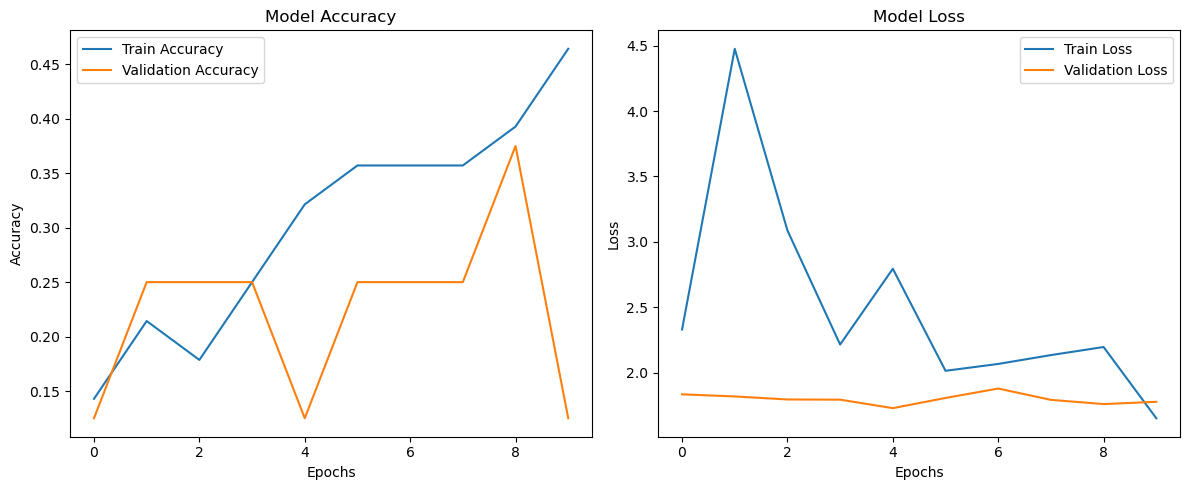

Training completed and model saved!


In [24]:
# %% [Main Execution]
if __name__ == "__main__":
    os.makedirs(config["save_dir"], exist_ok=True)
    
    # Configuration for optimization
    opt_config = {
        **config,
        "target_size": (255, 255),
        "input_shape": (255, 255, 3)
    }
    
    # Run optimization
    print("Starting hyperparameter optimization...")
    best_params = optimize_hyperparameters(opt_config, n_trials=5)
    print("Best parameters:", best_params)
    
    # Final training
    final_config = {
        **opt_config,
        **best_params,
        "epochs": 50,
        "augmentation": [
            A.Resize(width=255, height=255),
            A.HueSaturationValue(p=0.5),
            A.CLAHE(p=0.5),    
            A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=5, max_width=5),
        ]
    }
    
    print("Starting final training...")
    final_model, final_history = train_final_model(final_config)
    
    plot_accuracy_loss(final_history)
    
    # Save results
    final_model.save(os.path.join(config["save_dir"], 'final_model.keras'))
    with open(os.path.join(config["save_dir"], 'training_history.pkl'), 'wb') as f:
        pickle.dump(final_history.history, f)
    
    print("Training completed and model saved!")

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_saved_model(model_path, use_val_set=True):
    """Enhanced evaluation with comprehensive visualizations"""
    try:
        # Load model and label encoder
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(model_path, compile=False)
        cleanup_gpu_memory()
        
        # Calculate optimal batch size
        optimized_batch_size = calculate_max_batch_size(
            model, 
            input_shape=config["input_shape"],
            gpu_mem=config["gpu_memory_limit"],
            default_batch=config["batch_size"],
        )
        
        # Compile with additional metrics
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        # Load data
        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"\nEvaluating on {len(eval_df)} samples")
        
        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False
        )

        # 1. Standard Evaluation Metrics
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[EVALUATION METRICS]")
        for k, v in results.items():
            print(f"{k:20}: {v:.4f}")

        # 2. Collect predictions for detailed analysis
        y_true, y_pred, y_probs = [], [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_probs.extend(model.predict(x, verbose=0))
            y_pred.extend(np.argmax(y_probs[-len(y):], axis=1))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_probs = np.vstack(y_probs)

        # 3. Enhanced Visualizations
        plt.figure(figsize=(15, 12))
        
        # 3.1 Confusion Matrix (Normalized)
        plt.subplot(2, 2, 1)
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
        plt.title('Normalized Confusion Matrix')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        # 3.2 Class-wise Precision-Recall
        plt.subplot(2, 2, 2)
        precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1], pos_label=1)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')

        # 3.3 ROC Curve (for binary/multi-class)
        plt.subplot(2, 2, 3)
        if len(le.classes_) == 2:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            plt.plot(fpr, tpr, marker='.')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
        else:
            # Multi-class ROC
            for i in range(len(le.classes_)):
                fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
                plt.plot(fpr, tpr, label=le.classes_[i])
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC Curves')
            plt.legend()

        # 3.4 Prediction Distribution
        plt.subplot(2, 2, 4)
        pred_confidences = np.max(y_probs, axis=1)
        plt.hist(pred_confidences, bins=20)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Count')
        plt.title('Distribution of Prediction Confidences')

        plt.tight_layout()
        plt.show()

        # 4. Enhanced Classification Report
        print("\n[ENHANCED CLASSIFICATION REPORT]")
        print(classification_report(
            y_true, 
            y_pred, 
            target_names=le.classes_,
            digits=4
        ))

        # 5. Top Misclassified Examples
        print("\n[TOP MISCLASSIFIED EXAMPLES]")
        misclassified = np.where(y_true != y_pred)[0]
        if len(misclassified) > 0:
            top_misclassified = sorted(
                misclassified, 
                key=lambda i: y_probs[i][y_pred[i]], 
                reverse=True
            )[:5]
            
            plt.figure(figsize=(15, 5))
            for i, idx in enumerate(top_misclassified, 1):
                img = eval_gen[int(idx/optimized_batch_size)][0][idx%optimized_batch_size]
                plt.subplot(1, 5, i)
                plt.imshow(img)
                true_label = le.classes_[y_true[idx]]
                pred_label = le.classes_[y_pred[idx]]
                conf = y_probs[idx][y_pred[idx]]
                plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}")
                plt.axis('off')
            plt.suptitle('Top Misclassified Examples (Highest Confidence Wrong Predictions)')
            plt.show()

        return {
            'metrics': results,
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'classification_report': classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)
        }

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise

In [28]:
results = evaluate_saved_model("Model/training8_customCNN_rgb_att_SMOT_aug_bay_1/final_model.keras")

# Access specific results:
print("Test Accuracy:", results['metrics']['accuracy'])
print("Class-wise Performance:")
print(pd.DataFrame(results['classification_report']).transpose())


Evaluating on 8 samples
Evaluation failed: 'NoneType' object is not subscriptable


TypeError: 'NoneType' object is not subscriptable